##### About

This Python notebook aims to analyze the effect of a drug treatment using observational medical records, where the treatment assignment is not randomized. It focuses on identifying and adjusting for confounding factors, specifically smoking status, by computing propensity scores. The notebook goes through the process of:

- Prelimiary Data Analysis and visualization
- Calculating the ratio of smokers and non-smokers who received the drug treatment.  
- Updating each patient's propensity score based on their smoking status.  
- Matching patients from the treatment and control groups based on their propensity scores and ensuring equal dataset sizes by removing unmatched patients.  
- Calculating the Average Treatment Effect (ATE) to measure the drug's impact on survival outcomes.  

The objective is to estimate the drug's effectiveness by mimicking a randomized control setup using statistical adjustments for the confounding variables present in observational data.

Importing Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importing Data & Prelimiary Data Analysis

In [2]:
# Import the data
data_control = pd.read_csv('data_nodrug.csv')
data_treat = pd.read_csv('data_withdrug.csv')

In [3]:
data_control.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Number_of_symptoms,Survived_1_year,Drugs_treatment
0,22374,8,3333,56,18.479385,YES,URBAN,2.0,0.0,False
1,6283,23,10446,48,27.510027,YES,RURAL,1.0,0.0,False
2,10808,45,7977,47,26.155120,YES,URBAN,1.0,0.0,False
3,1647,17,10190,46,17.663877,NO,RURAL,2.0,1.0,False
4,14892,8,9461,60,18.690567,YES,URBAN,2.0,0.0,False


In [4]:
data_treat.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Number_of_symptoms,Survived_1_year,Drugs_treatment
0,18164,5,5740,36,22.945566,YES,RURAL,1.0,1.0,single_drug
1,5339,51,12011,5,19.130976,NO,URBAN,1.0,1.0,single_drug
2,5138,52,5296,53,19.103244,NO,RURAL,2.0,1.0,single_drug
3,17265,9,5947,3,18.126976,NO,URBAN,2.0,0.0,single_drug
4,24349,47,6585,62,25.074482,NO,URBAN,1.0,1.0,single_drug


In [5]:
# Check for missing values in both datasets
missing_values_nodrug = data_control.isnull().sum()
missing_values_withdrug = data_treat.isnull().sum()

if missing_values_nodrug.sum() == 0 and missing_values_withdrug.sum() == 0:
    print('There are no missing values in either dataset')
    

There are no missing values in either dataset


There are no missing values in either the data_nodrug.csv or data_withdrug.csv datasets for any of the variables. This is excellent as it means we won't need to perform imputation or remove rows due to missing data, allowing for a more straightforward analysis.

In [6]:
# Summary statistics of the datasets
data_control.describe()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,Number_of_symptoms,Survived_1_year
count,8148.000000,8148.000000,8148.000000,8148.000000,8148.000000,8148.000000,8148.000000
mean,16529.231345,26.312838,6266.368311,33.037555,23.523641,1.738095,0.408567
std,9532.762891,15.041784,3612.103117,19.471168,3.757868,0.766544,0.491599
min,4.000000,1.000000,2.000000,0.000000,17.000336,1.000000,0.000000
25%,8326.000000,13.000000,3173.250000,16.000000,20.263241,1.000000,0.000000
50%,16616.500000,26.000000,6198.500000,33.000000,23.490039,2.000000,0.000000
75%,24880.500000,39.000000,9442.250000,50.000000,26.839560,2.000000,1.000000
max,32974.000000,52.000000,12499.000000,66.000000,29.999579,5.000000,1.000000


In [7]:
data_treat.describe()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,Number_of_symptoms,Survived_1_year
count,13701.000000,13701.000000,13701.000000,13701.000000,13701.000000,13701.000000,13701.000000
mean,16508.442376,26.450989,6243.980147,33.348004,23.411614,1.758558,0.752719
std,9533.981685,15.015871,3591.592895,19.368521,3.783732,0.772488,0.431447
min,2.000000,1.000000,1.000000,0.000000,17.000336,1.000000,0.000000
25%,8180.000000,13.000000,3163.000000,17.000000,20.152461,1.000000,1.000000
50%,16535.000000,26.000000,6246.000000,33.000000,23.300138,2.000000,1.000000
75%,24752.000000,39.000000,9345.000000,50.000000,26.726534,2.000000,1.000000
max,32982.000000,52.000000,12500.000000,66.000000,29.999579,5.000000,1.000000


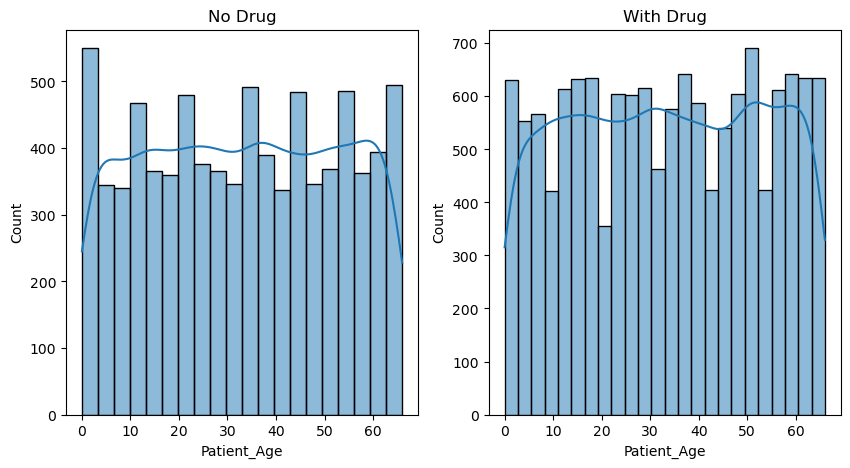

In [8]:
# Visualizing the distribution of both datasets (Age)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data_control['Patient_Age'], kde=True)
plt.title('No Drug')
plt.subplot(1, 2, 2)
sns.histplot(data_treat['Patient_Age'], kde=True)
plt.title('With Drug')
plt.show()

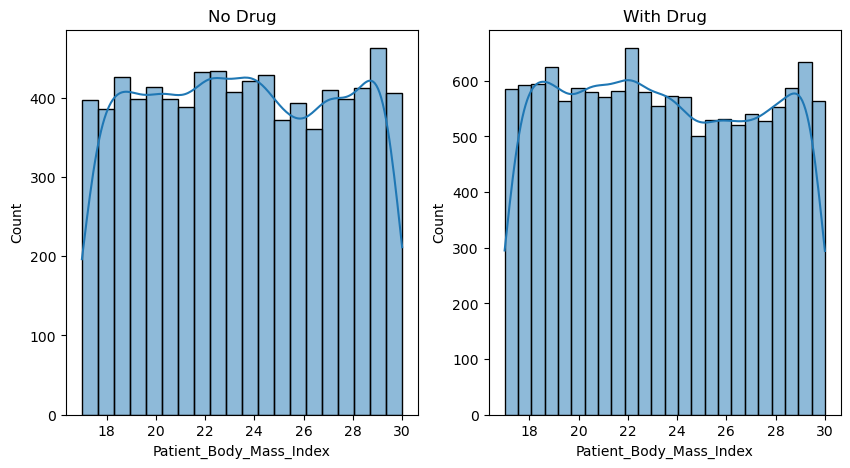

In [9]:
# Visualizing the distribution of both datasets (Patient_Body_Mass_Index)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data_control['Patient_Body_Mass_Index'], kde=True)
plt.title('No Drug')
plt.subplot(1, 2, 2)
sns.histplot(data_treat['Patient_Body_Mass_Index'], kde=True)
plt.title('With Drug')
plt.show()

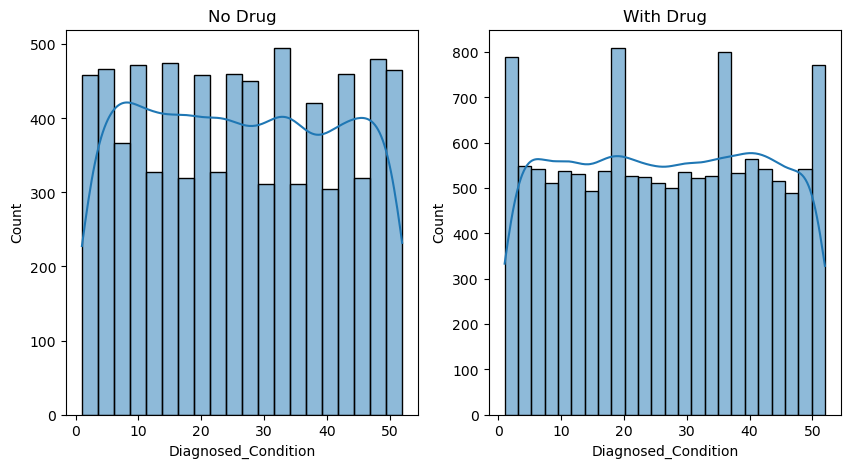

In [10]:
# Visualizing the distribution of both datasets (Diagnosed_Condition)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data_control['Diagnosed_Condition'], kde=True)
plt.title('No Drug')
plt.subplot(1, 2, 2)
sns.histplot(data_treat['Diagnosed_Condition'], kde=True)
plt.title('With Drug')
plt.show()

##### Q0: Data visualisation  


Plot a barplot with two categories, treated patients and control patients, such that the bar frequency shows the
number of smokers and non-smokers in each category

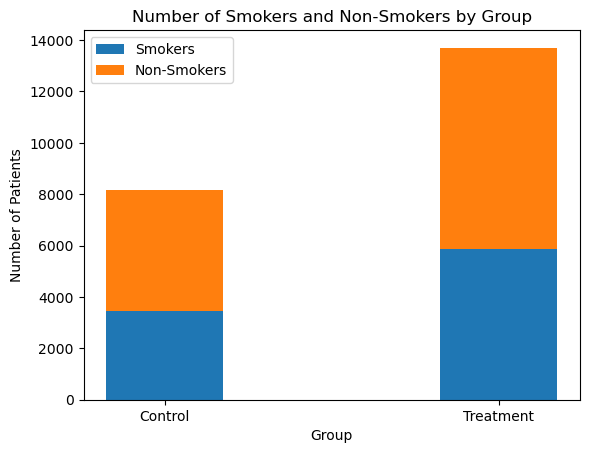

In [11]:
# Summarize the data for visualization
control_smokers = data_control['Patient_Smoker'].value_counts()
treat_smokers = data_treat['Patient_Smoker'].value_counts()

# Prepare data for plotting
categories = ['Control', 'Treatment']
smokers = [control_smokers.get('YES', 0), treat_smokers.get('YES', 0)]
nonsmokers = [control_smokers.get('NO', 0), treat_smokers.get('NO', 0)]

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, smokers, bar_width, label='Smokers')
bar2 = ax.bar(index, nonsmokers, bar_width, bottom=smokers, label='Non-Smokers')

ax.set_xlabel('Group')
ax.set_ylabel('Number of Patients')
ax.set_title('Number of Smokers and Non-Smokers by Group')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

In [12]:
# Identify outliers using the IQR method for 'Patient_Age' and 'Patient_Body_Mass_Index' in both datasets
# Calculate IQR
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers[column].count()

outliers_nodrug_age = identify_outliers(data_control, 'Patient_Age')
outliers_nodrug_bmi = identify_outliers(data_control, 'Patient_Body_Mass_Index')
outliers_withdrug_age = identify_outliers(data_treat, 'Patient_Age')
outliers_withdrug_bmi = identify_outliers(data_treat, 'Patient_Body_Mass_Index')


print('No Drug Dataset')
print('Outliers in Patient Age:', outliers_nodrug_age)
print('Outliers in Patient Body Mass Index:', outliers_nodrug_bmi)
print("-------------------")
print('With Drug Dataset')
print('Outliers in Patient Age:', outliers_withdrug_age)
print('Outliers in Patient Body Mass Index:', outliers_withdrug_bmi)


No Drug Dataset
Outliers in Patient Age: 0
Outliers in Patient Body Mass Index: 0
-------------------
With Drug Dataset
Outliers in Patient Age: 0
Outliers in Patient Body Mass Index: 0


Using the Interquartile Range (IQR) method for detecting outliers, there seems to be no outliers in the Patient_Age and Patient_Body_Mass_Index variables in either dataset. This outcome suggests that the data for these key covariates is relatively well-behaved, without extreme values that could skew the analysis.

In [13]:
# Merge datasets to include treatment indicator
data_control['Treatment'] = 'No Drug'
data_treat['Treatment'] = 'With Drug'

# Standardize the Drugs_treatment column in the withdrug dataset for consistency
data_treat['Drugs_treatment'] = data_treat['Drugs_treatment'].apply(lambda x: True if x != '0' else False)

# Combine the datasets for comparative analysis
combined_data = pd.concat([data_control, data_treat], axis=0)

# Calculate summary statistics for continuous variables by treatment
summary_stats_continuous = combined_data.groupby('Treatment')[['Patient_Age', 'Patient_Body_Mass_Index']].describe()

# Calculate proportions for categorical variables by treatment
summary_stats_categorical = combined_data.groupby('Treatment')[['Patient_Smoker', 'Patient_Rural_Urban']].agg(lambda x: x.value_counts(normalize=True))

summary_stats_continuous, summary_stats_categorical

(          Patient_Age                                                     \
                 count       mean        std  min   25%   50%   75%   max   
 Treatment                                                                  
 No Drug        8148.0  33.037555  19.471168  0.0  16.0  33.0  50.0  66.0   
 With Drug     13701.0  33.348004  19.368521  0.0  17.0  33.0  50.0  66.0   
 
           Patient_Body_Mass_Index                                             \
                             count       mean       std        min        25%   
 Treatment                                                                      
 No Drug                    8148.0  23.523641  3.757868  17.000336  20.263241   
 With Drug                 13701.0  23.411614  3.783732  17.000336  20.152461   
 
                                             
                  50%        75%        max  
 Treatment                                   
 No Drug    23.490039  26.839560  29.999579  
 With Drug  23.300138 

Patient Age:  
- No Drug Group: Mean age ≈ 33.04 years, with a standard deviation (SD) of ≈ 19.47 years.  
- With Drug Group: Mean age ≈ 33.35 years, with a SD of ≈ 19.37 years.  
- The age distribution is remarkably similar between the two groups, suggesting good balance for this covariate.  

Patient Body Mass Index (BMI):  
- No Drug Group: Mean BMI ≈ 23.52, with a SD of ≈ 3.76.  
- With Drug Group: Mean BMI ≈ 23.41, with a SD of ≈ 3.78.  
- BMI distributions are also similar, indicating a balanced covariate.  
- Categorical Variables (Patient Smoker and Rural/Urban)    
  
Patient Smoker:  
Proportions: Both groups have similar proportions of smokers to non-smokers, with the no-drug group having ≈ 57.6% non-smokers and the with-drug group ≈ 57.1% non-smokers.  

Patient Rural/Urban:  
Proportions: There is a slight difference in the rural/urban distribution, with the no-drug group having ≈ 70.4% rural patients and the with-drug group ≈ 69.6% rural patients.  

##### Q1: Compute ratio

By utilizing two datasets loaded above, compute the ratio of treated patients who are smoker, e_smoker,
and the ratio of treated patients who are non-smoker, e_non_smoker.

In [14]:
# Calculate the numbers needed for the ratios
n_smokers = data_control[data_control['Patient_Smoker'] == 'YES'].shape[0] + data_treat[data_treat['Patient_Smoker'] == 'YES'].shape[0]
n_non_smokers = data_control[data_control['Patient_Smoker'] == 'NO'].shape[0] + data_treat[data_treat['Patient_Smoker'] == 'NO'].shape[0]
n_treated_smokers = data_treat[data_treat['Patient_Smoker'] == 'YES'].shape[0]
n_treated_non_smokers = data_treat[data_treat['Patient_Smoker'] == 'NO'].shape[0]

# Compute the ratios
e_smoker = n_treated_smokers / n_smokers
e_non_smoker = n_treated_non_smokers / n_non_smokers

print('The ratio of smokers in the treatment group to smokers in the control group is:', e_smoker)
print('The ratio of non-smokers in the treatment group to non-smokers in the control group is:', e_non_smoker)

The ratio of smokers in the treatment group to smokers in the control group is: 0.629796355841372
The ratio of non-smokers in the treatment group to non-smokers in the control group is: 0.6250499241153447


The ratios indicate the proportion of smokers and non-smokers who received treatment is fairly similar, with both groups having 63% and 62.5% of their respective populations receiving treatment. This suggests that, in terms of smoking status, the treatment allocation between smokers and non-smokers is balanced.

##### Q2: Propensity score

The propensity score is defined formally as follows:  
e(smoker = 1) = P(treatment = 1 | smoker = 1)  
e(smoker = 0) = P(treatment = 1 | smoker = 0)  
By treating the ratio computed in Q1 as an estimate of the propensity score for smoker patients and nonsmoker patients, add a column of propensity score in both datasets.  

By comparing those two propensity scores, together with the barplot in Q0, can you explain why smoke feature here is not a confounding factor?  

In [15]:
# Adding the propensity score columns to both datasets
data_control['Propensity_Score'] = data_control['Patient_Smoker'].apply(lambda x: e_smoker if x == 'YES' else e_non_smoker)
data_treat['Propensity_Score'] = data_treat['Patient_Smoker'].apply(lambda x: e_smoker if x == 'YES' else e_non_smoker)

In [16]:
data_control.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Number_of_symptoms,Survived_1_year,Drugs_treatment,Treatment,Propensity_Score
0,22374,8,3333,56,18.479385,YES,URBAN,2.0,0.0,False,No Drug,0.629796
1,6283,23,10446,48,27.510027,YES,RURAL,1.0,0.0,False,No Drug,0.629796
2,10808,45,7977,47,26.155120,YES,URBAN,1.0,0.0,False,No Drug,0.629796
3,1647,17,10190,46,17.663877,NO,RURAL,2.0,1.0,False,No Drug,0.625050
4,14892,8,9461,60,18.690567,YES,URBAN,2.0,0.0,False,No Drug,0.629796


In [17]:
data_treat.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Number_of_symptoms,Survived_1_year,Drugs_treatment,Treatment,Propensity_Score
0,18164,5,5740,36,22.945566,YES,RURAL,1.0,1.0,True,With Drug,0.629796
1,5339,51,12011,5,19.130976,NO,URBAN,1.0,1.0,True,With Drug,0.625050
2,5138,52,5296,53,19.103244,NO,RURAL,2.0,1.0,True,With Drug,0.625050
3,17265,9,5947,3,18.126976,NO,URBAN,2.0,0.0,True,With Drug,0.625050
4,24349,47,6585,62,25.074482,NO,URBAN,1.0,1.0,True,With Drug,0.625050


The propensity score for smokers (e_smoker) and non-smokers (e_non_smoker) are approximately equal, both around 0.63. This means that the probabilty of receiving treatment is roughly the same for both smokers and non-smokers. The barplot from Q0 also shows a similar representation in both the control and treatment group (suggesting the distribution  is quiet balanced across the 2 groups).   

Since the probability of receiving treatment is almost equal for both smokers and non-smokers, smoking status does not appear to be a confounding factor. A confounding factor is a variable that influences both the treatment assignment and the outcome variable, potentially leading to bias.  In this case, it seems the probability of receiving treatment is independent of whether the patient is a smoker or non-smoker, hence we can see smoking status is not a confounding factor.

##### Q3: Pair match

One of the ways for categorical confounding factor is to couple each treated patient with a control patient that has the same propensity score. By utilising the function provided below, complete the list of matched control.

In [18]:
matched_control = []

def add_matched_control(patient):
    control_patient = data_control [data_control["Propensity_Score"] == patient["Propensity_Score"]].sample().iloc[0]
    matched_control.append(control_patient)

# Apply the function to each treated patient
data_treat.apply(add_matched_control, axis=1)

matched_control_df = pd.DataFrame(matched_control) # Convert the list to a DataFrame

In [19]:
matched_control_df.head()

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Number_of_symptoms,Survived_1_year,Drugs_treatment,Treatment,Propensity_Score
1673,2391,6,1467,42,20.027213,YES,URBAN,2.0,0.0,False,No Drug,0.629796
2011,32907,11,5202,51,20.074712,NO,RURAL,2.0,1.0,False,No Drug,0.625050
3369,1517,45,10826,53,24.792151,NO,URBAN,2.0,1.0,False,No Drug,0.625050
7479,14524,1,11568,14,19.054146,NO,URBAN,2.0,1.0,False,No Drug,0.625050
1072,21088,33,5310,0,24.810434,NO,RURAL,2.0,0.0,False,No Drug,0.625050


##### Q4: ATE

Compute the ATE which equal to the mean of the difference of survival between treated patients and matched control patients.

Comments about the value of ATE and its implication.

In [20]:
ate = (data_treat['Survived_1_year'] - matched_control_df['Survived_1_year']).mean()

print('The Average Treatment Effect (ATE) is:', ate)

The Average Treatment Effect (ATE) is: 0.34625209838697907


The computed Average Treatment Effect (ATE) is approximately 0.346, which implies that, on average, the treatment has a beneficial effect on survival, as the treated patients tend to survive more often than the matched control patients by about 34.6%.  

If the analysis is correct and all key confounders are adequately controlled for, the positive ATE would support the use of the treatment in the patient population similar to those in the study. It indicates that the treatment may be a beneficial for improving survival outcomes for a population. Although further detailed analysis is required, and better Quality of Matching methods need to be used and ofcoure randomized controlled trials or additional observational studies with comprehensive covariate adjustment can confirm if this treatment shall be used for the general population.

##### Reflection & Summary

- Planned on measuring the Average Treatment Effect (ATE) of drug treatment from non-randomized medical records.  

- Performed preliminary analysis on the dataset, including checking for N/A values, outliers, and comparitive analysis

- Calculated the ratio of smokers and non-smokers receiving the treatment to identify the influence of smoking as a confounder.  

- Computed propensity scores for each patient to balance comparison groups based on their characteristics.  

- Reordered data by propensity scores to accurately match patients with and without treatment, removing unmatched cases.  

- Determined the ATE by comparing survival outcomes between treated and untreated groups, providing insights into treatment effectiveness.  

- Highlighted the significance of adjusting for confounders in observational studies to obtain meaningful conclusions. 

Note to self: Need to study up on better quality of matching methods.